In [1]:
# default_exp models.tcn.tcn

In [2]:
#hide
%load_ext autoreload
%autoreload 2

In [3]:
#export
import os
import time
import numpy as np
import pandas as pd
import random
from collections import defaultdict
import copy

import torch as t
from torch import optim
from pathlib import Path
from functools import partial

from nixtla.models.tcn.tcn_model import TCNModule
from nixtla.losses.pytorch import MAPELoss, MASELoss, SMAPELoss, MSELoss, MAELoss
from nixtla.losses.numpy import mae, mse, mape, smape, rmse

In [4]:
#export
def init_weights(module, initialization):
    if type(module) == t.nn.Linear:
        if initialization == 'orthogonal':
            t.nn.init.orthogonal_(module.weight)
        elif initialization == 'he_uniform':
            t.nn.init.kaiming_uniform_(module.weight)
        elif initialization == 'he_normal':
            t.nn.init.kaiming_normal_(module.weight)
        elif initialization == 'glorot_uniform':
            t.nn.init.xavier_uniform_(module.weight)
        elif initialization == 'glorot_normal':
            t.nn.init.xavier_normal_(module.weight)
        elif initialization == 'lecun_normal':
            pass #t.nn.init.normal_(module.weight, 0.0, std=1/np.sqrt(module.weight.numel()))
        else:
            assert 1<0, f'Initialization {initialization} not found'

class TCN(object):
    """
    Future documentation
    """

    def __init__(self,
                 input_size_multiplier,
                 output_size,
                 n_channels,
                 kernel_size,
                 initialization,
                 learning_rate,
                 lr_decay,
                 n_lr_decay_steps,
                 weight_decay,
                 l1_inputs,
                 dropout_prob,
                 max_epochs,
                 early_stopping,
                 loss,
                 frequency,
                 random_seed,
                 seasonality,
                 device=None):
        super(TCN, self).__init__()

        #------------------------ Model Attributes ------------------------#
        # Architecture parameters
        self.input_size = int(input_size_multiplier*output_size)
        self.output_size = output_size
        self.initialization = initialization
        self.n_channels = n_channels
        self.kernel_size = kernel_size

        # Regularization and optimization parameters
        self.learning_rate = learning_rate
        self.lr_decay = lr_decay
        self.n_lr_decay_steps = n_lr_decay_steps
        self.weight_decay = weight_decay
        self.max_epochs = max_epochs
        self.early_stopping = early_stopping
        self.loss = loss
        self.l1_inputs = l1_inputs
        self.dropout_prob = dropout_prob

        # Other
        self.frequency = frequency
        self.seasonality = seasonality
        self.random_seed = random_seed

        if device is None:
            device = 'cuda' if t.cuda.is_available() else 'cpu'
        self.device = device

        self._is_instantiated = False

    def __loss_fn(self, loss_name: str):
        def loss(x, freq, forecast, target, mask):
            if loss_name == 'MAPE':
                return MAPELoss(y=target, y_hat=forecast, mask=mask) + \
                       self.loss_l1_inputs()
            elif loss_name == 'MASE':
                return MASELoss(y=target, y_hat=forecast, y_insample=x, seasonality=freq, mask=mask) + \
                       self.loss_l1_inputs()
            elif loss_name == 'SMAPE':
                return SMAPELoss(y=target, y_hat=forecast, mask=mask) + self.loss_l1_inputs()
            elif loss_name == 'MSE':
                return MSELoss(y=target, y_hat=forecast, mask=mask) + \
                       self.loss_l1_inputs()
            elif loss_name == 'MAE':
                return MAELoss(y=target, y_hat=forecast, mask=mask) + \
                       self.loss_l1_inputs()
            else:
                raise Exception(f'Unknown loss function: {loss_name}')
        return loss

    def __val_loss_fn(self, loss_name='MAE'):
        #TODO: mase not implemented
        def loss(forecast, target, weights):
            if loss_name == 'MAPE':
                return mape(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'SMAPE':
                return smape(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'MSE':
                return mse(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'RMSE':
                return rmse(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'MAE':
                return mae(y=target, y_hat=forecast, weights=weights)
            else:
                raise Exception(f'Unknown loss function: {loss_name}')
        return loss
    
    def loss_l1_inputs(self):
        loss_l1 = 0
        # for i, indicator in enumerate(self.blocks_regularizer):
        #     if indicator:
        #         loss_l1 += self.l1_inputs * t.sum(t.abs(self.model.blocks[i].basis.weight))
        return loss_l1

    def to_tensor(self, x: np.ndarray) -> t.Tensor:
        tensor = t.as_tensor(x, dtype=t.float32).to(self.device)
        return tensor

    def evaluate_performance(self, ts_loader, validation_loss_fn):
        #TODO: mas opciones que mae
        self.model.eval()

        losses = []
        with t.no_grad():
            for batch in iter(ts_loader):
                # Parse batch
                insample_y     = self.to_tensor(batch['insample_y'])
                insample_x     = self.to_tensor(batch['insample_x'])
                insample_mask  = self.to_tensor(batch['insample_mask'])
                outsample_x    = self.to_tensor(batch['outsample_x'])
                outsample_y    = self.to_tensor(batch['outsample_y'])
                outsample_mask = self.to_tensor(batch['outsample_mask'])
                s_matrix       = self.to_tensor(batch['s_matrix'])

                forecast = self.model.predict(insample_y=insample_y, insample_x=insample_x)

                batch_loss = validation_loss_fn(target=forecast.cpu().data.numpy(),
                                                forecast=outsample_y.cpu().data.numpy(),
                                                weights=outsample_mask.cpu().data.numpy())
                losses.append(batch_loss)
        loss = np.mean(losses)
        self.model.train()
        return loss

    def fit(self, train_ts_loader, val_ts_loader=None, max_epochs=None, verbose=True, eval_epochs=1):
        # TODO: Indexes hardcoded, information duplicated in train and val datasets
        assert (self.input_size)==train_ts_loader.input_size, \
            f'model input_size {self.input_size} data input_size {train_ts_loader.input_size}'

        # Random Seeds (model initialization)
        t.manual_seed(self.random_seed)
        np.random.seed(self.random_seed)
        random.seed(self.random_seed) #TODO: interaccion rara con window_sampling de validacion

        # Attributes of ts_dataset
        self.n_x_t, _ = train_ts_loader.get_n_variables()
        self.n_x_t += 1 # add y

        # Instantiate model
        if not self._is_instantiated:
            self.model = TCNModule(output_size=self.output_size, num_inputs = self.n_x_t,
                                   num_channels=self.n_channels,
                                   kernel_size=self.kernel_size, dropout=self.dropout_prob)
            init_function = partial(init_weights, initialization=self.initialization)
            self.model.apply(init_function)
            self.model = self.model.to(self.device)
            self._is_instantiated = True

        # Overwrite n_iterations and train datasets
        if max_epochs is None:
            max_epochs = self.max_epochs

        lr_decay_steps = max_epochs // self.n_lr_decay_steps
        if lr_decay_steps == 0:
            lr_decay_steps = 1

        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_steps, gamma=self.lr_decay)
        training_loss_fn = self.__loss_fn(self.loss)
        validation_loss_fn = self.__val_loss_fn(self.loss) #Uses numpy losses

        if verbose and (max_epochs > 0):
            print('='*30+' Start fitting '+'='*30)
            print(f'Number of exogenous variables: {self.n_x_t}')
            #print(f'Number of static variables: {self.n_x_s} , with dim_hidden: {self.x_s_n_hidden}')
            print(f'Number of epochs: {max_epochs}')

        #self.loss_dict = {} # Restart self.loss_dict
        start = time.time()
        self.trajectories = {'epoch':[],'train_loss':[], 'val_loss':[]}
        self.final_insample_loss = None
        self.final_outsample_loss = None

        # Training Loop
        early_stopping_counter = 0
        best_val_loss = np.inf
        best_state_dict = copy.deepcopy(self.model.state_dict())
        break_flag = False
        epoch = 0
        while (epoch < max_epochs) and (not break_flag):
            epoch +=1
            for batch in iter(train_ts_loader):
                if (epoch > max_epochs) or (break_flag):
                    continue

                self.model.train()
                train_ts_loader.train()
                # Parse batch
                insample_y     = self.to_tensor(batch['insample_y'])
                insample_x     = self.to_tensor(batch['insample_x'])
                insample_mask  = self.to_tensor(batch['insample_mask'])
                outsample_x    = self.to_tensor(batch['outsample_x'])
                outsample_y    = self.to_tensor(batch['outsample_y'])
                outsample_mask = self.to_tensor(batch['outsample_mask'])
                s_matrix       = self.to_tensor(batch['s_matrix'])

                optimizer.zero_grad()
                forecast, outsample_y = self.model(insample_y=insample_y, insample_x=insample_x,
                                                  insample_mask=insample_mask, outsample_y=outsample_y)

                training_loss = training_loss_fn(x=insample_y, freq=self.seasonality, forecast=forecast,
                                                target=outsample_y, mask=outsample_mask)

                if np.isnan(float(training_loss)):
                    break

                training_loss.backward()
                t.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

            lr_scheduler.step()
            if (epoch % eval_epochs == 0):
                display_string = 'Step: {}, Time: {:03.3f}, Insample {}: {:.5f}'.format(epoch,
                                                                                time.time()-start,
                                                                                self.loss,
                                                                                training_loss.cpu().data.numpy())
                self.trajectories['epoch'].append(epoch)
                self.trajectories['train_loss'].append(training_loss.cpu().data.numpy())

                if val_ts_loader is not None:
                    loss = self.evaluate_performance(ts_loader=val_ts_loader, 
                                                    validation_loss_fn=validation_loss_fn)
                    display_string += ", Outsample {}: {:.5f}".format(self.loss, loss)
                    self.trajectories['val_loss'].append(loss)

                    if self.early_stopping:
                        if loss < best_val_loss:
                            # Save current model if improves outsample loss
                            best_state_dict = copy.deepcopy(self.model.state_dict())
                            best_insample_loss = training_loss.cpu().data.numpy()
                            early_stopping_counter = 0
                            best_val_loss = loss
                        else:
                            early_stopping_counter += 1
                        if early_stopping_counter >= self.early_stopping:
                            break_flag = True
                
                print(display_string)

                self.model.train()
                train_ts_loader.train()

            if break_flag:
                print(10*'-',' Stopped training by early stopping', 10*'-')
                self.model.load_state_dict(best_state_dict)
                break

        #End of fitting
        if max_epochs >0:
            self.final_insample_loss = training_loss.cpu().data.numpy() if not break_flag else best_insample_loss #This is batch!
            string = 'epoch: {}, Time: {:03.3f}, Insample {}: {:.5f}'.format(epoch,
                                                                            time.time()-start,
                                                                            self.loss,
                                                                            self.final_insample_loss)
            if val_ts_loader is not None:
                self.final_outsample_loss = self.evaluate_performance(ts_loader=val_ts_loader, 
                                                                      validation_loss_fn=validation_loss_fn)
                string += ", Outsample {}: {:.5f}".format(self.loss, self.final_outsample_loss)
            print(string)
            print('='*30+'End fitting '+'='*30)

    def predict(self, ts_loader, X_test=None, eval_mode=False):

        ts_loader.eval()
        frequency = ts_loader.get_frequency()

        # Build forecasts
        unique_ids = ts_loader.get_meta_data_col('unique_id')
        last_ds = ts_loader.get_meta_data_col('last_ds') #TODO: ajustar of offset

        self.model.eval()
        with t.no_grad():
            forecasts = []
            outsample_ys = []
            outsample_masks = []
            for batch in iter(ts_loader):
                insample_y     = self.to_tensor(batch['insample_y'])
                insample_x     = self.to_tensor(batch['insample_x'])
                insample_mask  = self.to_tensor(batch['insample_mask'])
                outsample_x    = self.to_tensor(batch['outsample_x'])
                outsample_y    = self.to_tensor(batch['outsample_y'])
                outsample_mask = self.to_tensor(batch['outsample_mask'])
                s_matrix       = self.to_tensor(batch['s_matrix'])

                forecast = self.model.predict(insample_y=insample_y, insample_x=insample_x)
                forecasts += [forecast.cpu().data.numpy()]
                outsample_ys += [outsample_y.cpu().data.numpy()]
                outsample_masks += [outsample_mask.cpu().data.numpy()]
        forecasts = np.vstack(forecasts)
        outsample_ys = np.vstack(outsample_ys)
        outsample_masks = np.vstack(outsample_masks)

        if eval_mode:
            return forecasts, outsample_ys, outsample_masks

        # Predictions for panel
        Y_hat_panel = pd.DataFrame(columns=['unique_id', 'ds'])
        for i, unique_id in enumerate(unique_ids):
            Y_hat_id = pd.DataFrame([unique_id]*self.output_size, columns=["unique_id"])
            ds = pd.date_range(start=last_ds[i], periods=self.output_size+1, freq=frequency)
            Y_hat_id["ds"] = ds[1:]
            Y_hat_panel = Y_hat_panel.append(Y_hat_id, sort=False).reset_index(drop=True)

        Y_hat_panel['y_hat'] = forecasts.flatten()

        if X_test is not None:
            Y_hat_panel = X_test.merge(Y_hat_panel, on=['unique_id', 'ds'], how='left')
        
        return Y_hat_panel


    def save(self, model_dir, model_id, state_dict = None):
    
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        if state_dict is None:
            state_dict = self.model.state_dict()

        model_file = os.path.join(model_dir, f"model_{model_id}.model")
        print('Saving model to:\n {}'.format(model_file)+'\n')
        t.save({'model_state_dict': state_dict}, model_file)

    def load(self, model_dir, model_id):

        model_file = os.path.join(model_dir, f"model_{model_id}.model")
        path = Path(model_file)

        assert path.is_file(), 'No model_*.model file found in this path!'

        print('Loading model from:\n {}'.format(model_file)+'\n')

        checkpoint = t.load(model_file, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)

In [5]:
import time
import numpy as np
import pandas as pd
import random
import torch as t
import copy
import matplotlib.pyplot as plt

from nixtla.data.tsdataset import TimeSeriesDataset
from nixtla.data.tsloader_general import TimeSeriesLoader as TimeSeriesLoaderGeneral

from nixtla.data.datasets.epf import EPF, EPFInfo

In [6]:
Y_df, X_df = EPF.load(directory='data', group=EPFInfo.groups[0])

std = X_df['Exogenous1'].std()
mean = X_df['Exogenous1'].mean()
X_df['Exogenous1'] = (X_df['Exogenous1']-mean)/std

std = X_df['Exogenous2'].std()
mean = X_df['Exogenous2'].mean()
X_df['Exogenous2'] = (X_df['Exogenous2']-mean)/std


train_outsample_mask = np.ones(len(Y_df))
train_outsample_mask[-365 * 24:] = 0
sum(train_outsample_mask)
epf_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=None, ts_train_mask=train_outsample_mask)

Y_df.head()

Processing dataframes ...
Creating ts tensor ...


,unique_id,ds,y
0,NP,2013-01-01 00:00:00,31.05
1,NP,2013-01-01 01:00:00,30.47
2,NP,2013-01-01 02:00:00,28.92
3,NP,2013-01-01 03:00:00,27.88
4,NP,2013-01-01 04:00:00,26.96


In [7]:
train_loader = TimeSeriesLoaderGeneral(ts_dataset=epf_dataset,
                                    model='tcn',
                                    offset=24,
                                    window_sampling_limit=365*4*24, 
                                    input_size=7*24,
                                    output_size=24,
                                    idx_to_sample_freq=1,
                                    batch_size=1024,
                                    is_train_loader=True)

val_loader = TimeSeriesLoaderGeneral(ts_dataset=epf_dataset,
                                  model='tcn',
                                  offset=24,
                                  window_sampling_limit=365*4*24, 
                                  input_size=7*24,
                                  output_size=24,
                                  idx_to_sample_freq=1,
                                  batch_size=1024,
                                  is_train_loader=False)

In [21]:
tcn = TCN(input_size_multiplier=7,
          output_size=24,
          n_channels = [1, 1, 1],
          kernel_size=4,
          initialization='lecun_normal',
          learning_rate=0.001,
          lr_decay=0.5,
          n_lr_decay_steps=3,
          weight_decay=0,
          l1_inputs=0,
          dropout_prob=0.1,
          max_epochs=300,
          early_stopping=10,
          loss='MAE',
          frequency='H',
          random_seed=1,
          seasonality=24,
          device=None)

In [22]:
tcn.fit(train_ts_loader=train_loader, val_ts_loader = val_loader, eval_epochs=10)

============================== Start fitting ==============================
Number of exogenous variables: 1
Number of epochs: 300
Step: 10, Time: 2.744, Insample MAE: 0.51935, Outsample MAE: 3.49292
Step: 20, Time: 5.837, Insample MAE: 0.54305, Outsample MAE: 2.55709
Step: 30, Time: 8.919, Insample MAE: 0.52435, Outsample MAE: 2.61429
Step: 40, Time: 12.013, Insample MAE: 0.48858, Outsample MAE: 2.78423
Step: 50, Time: 15.082, Insample MAE: 0.47803, Outsample MAE: 2.73549
Step: 60, Time: 18.149, Insample MAE: 0.57190, Outsample MAE: 2.51115
Step: 70, Time: 21.243, Insample MAE: 0.46495, Outsample MAE: 2.86547
Step: 80, Time: 24.341, Insample MAE: 0.49064, Outsample MAE: 2.61481
Step: 90, Time: 27.469, Insample MAE: 0.48567, Outsample MAE: 2.67108
Step: 100, Time: 30.582, Insample MAE: 0.51734, Outsample MAE: 2.94346
Step: 110, Time: 33.667, Insample MAE: 0.52287, Outsample MAE: 2.87807
Step: 120, Time: 36.754, Insample MAE: 0.50482, Outsample MAE: 2.83570
Step: 130, Time: 39.819, Insa

In [23]:
y_hat = tcn.predict(ts_loader=train_loader)

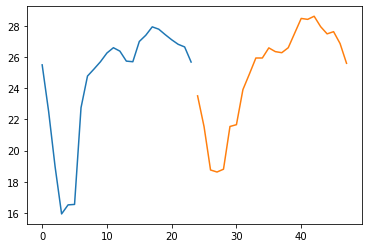

In [24]:
y_plot = Y_df.tail(24)['y']
y_hat_plot = y_hat['y_hat']
plt.plot(range(len(y_plot)), y_plot)
plt.plot(range(len(y_plot), len(y_plot)+len(y_hat_plot)), y_hat_plot)

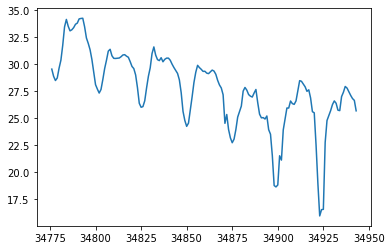

In [25]:
plt.plot(Y_df['y'][-168:])